# Managing cohorts

This library allows users to apply certain mitigations over a specific cohort, instead of ​applying it to the entire dataset. This is useful when, for example, two cohorts have a very different label distribution and we want to rebalance each cohort individually, instead of rebalancing the entire dataset. In some scenarios, applying a mitigation over each cohort separately is more advantageous than applying it over the whole dataset.

In this notebook, we'll show how to apply different pipelines for each cohort separately. To accomplish this, we'll use the `CohortManager` class. This class allows us to create multiple pipelines (using transformers from `scikit-learn` or from the current library) and apply them to each cohort separately. All this is done following the ``fit()`` and ``transform()`` paradigms, ​similar  to the other mitigations from the `dataprocessing` module.

First of all, let's import the ``CohortManager`` class, which is found in the `cohort` module.

In [1]:
import random
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.pipeline import Pipeline

import raimitigations.dataprocessing as dp
from raimitigations.cohort import CohortDefinition, CohortManager

SEED = 42

## Toy dataset

Next, we'll create a toy dataset so we can showcase how the ``CohortManager`` operates.

In [2]:
def create_df(with_null: bool = True):
    np.random.seed(SEED)
    random.seed(SEED)
    def add_nan(vec, pct):
        vec = list(vec)
        nan_index = random.sample(range(len(vec)), int(pct * len(vec)))
        for index in nan_index:
            vec[index] = np.nan
        return vec

    df = dp.create_dummy_dataset(
        samples=1000,
        n_features=2,
        n_num_num=0,
        n_cat_num=2,
        n_cat_cat=0,
        num_num_noise=[0.01, 0.05],
        pct_change=[0.05, 0.1],
    )
    if with_null:
        col_with_nan = ["num_0", "num_1"]
        for col in col_with_nan:
            if col != "label":
                df[col] = add_nan(df[col], 0.1)

    X = df.drop(columns=["label"])
    y = df[["label"]]

    return X, y

# -----------------------------------
def get_model():
    model = xgb.XGBClassifier(
            objective="binary:logistic",
            learning_rate=0.1,
            n_estimators=30,
            max_depth=10,
            colsample_bytree=0.7,
            alpha=0.0,
            reg_lambda=10.0,
            nthreads=4,
            verbosity=0,
            use_label_encoder=False,
        )
    return model

In [3]:
X, y = create_df()
X

,num_0,num_1,CN_0_num_0,CN_1_num_1
0,1.601034,2.535353,val0_0,val1_3
1,1.755945,-2.172352,val0_1,val1_0
2,2.354479,NaN,val0_0,val1_0
3,4.103090,-0.766515,val0_1,val1_2
4,1.753178,1.787514,val0_0,val1_1
...,...,...,...,...
995,2.713939,1.451639,val0_1,val1_2
996,1.420812,2.535627,val0_0,val1_3
997,3.844315,1.211294,val0_1,val1_2
998,0.974124,2.619258,val0_0,val1_3


## Basic scenario

Next, we'll explore a basic scenario where the ``CohortManager`` can prove its usefulness. In this scenario, we want to apply an imputation, followed by a min max scaler over each cohort separately. Once again: this is useful when each cohort has different behaviors or distributions for a particular column, so applying an imputation based on the mean value of the column over each cohort separately will make more sense than using the mean of the column of the entire dataset, for example.

The `CohortManager` requires two main parameters: a transformation pipeline and a list of cohort definitions. The latter is already explored and explained in the notebook showcasing the `CohortDefinition` class (which is used internally by the `CohortManager`). The former is simply a list of objects that implement the `fit()`, `transform()`, `predict()` paradigm, or the `fit_resample()` method (for rebalancing classes, such as the `Rebalance` class from the `dataprocessing` module, or the rebalance classes from the `imblearn` library).

There are two constraints when defining the cohorts:
1. The definitions must not allow any instance to belong to more than 1 cohort. If that happens, an error is raised;
2. The definitions must include all instances (without repetition due to the previous constraint). Since in some cases it is difficult to define a set of conditions for the last cohort such that it includes all instances not belonging to any of the previous cohorts, we created an easier way to accomplish this: the condition list for the last cohort is allowed to be `None`. When this happens, this cohort is understood as being the one with all the remaining instances that don't belong to any of the other cohorts.

Once we instantiate the `CohortManager` object, we can treat it similarly to other classes from the `dataprocessing` module: call the `fit()` and `transform()` methods. Internally, what will happen is the following: 
1. the cohort pipeline will be duplicated, such that we'll have one pipeline for each cohort, with different objects instantiation;
2. during the `fit()` method, we'll cycle through all cohorts, and for each cohort:
    * we'll first filter the dataset provided (in this case, `X` and `y`) so that it includes only instances that belong to the current cohort;
    * with the subset of the current cohort, we'll call the `fit()` method for all the transformations in the cohort's pipeline (in the order in which they appear) using the subset dataset as input;
4. during the ``transform()`` method, we'll use a similar approach, but instead of calling the `fit()` method for the transformers in each cohort's pipeline, this time we'll call the `transform()` method;
    * if all cohorts are compatible with each other, that is, have the same columns after applying all transforms, then all subsets are concatenated together. The full dataset is then returned. If there are any inconsistencies between the cohorts, then we'll just add each subset into a list of subsets, and the final variable returned in this case is a list of subsets (we'll explore some examples ahead).

In [4]:
cohort_pipeline = [
    dp.BasicImputer(verbose=False),
    dp.DataMinMaxScaler(verbose=False),
]

c1 = [ ['CN_0_num_0', '==', 'val0_1'], 'and', ['num_0', '>', 0.0] ]
c2 = [ ['CN_0_num_0', '==', 'val0_0'], 'and', ['num_0', '>', 0.0] ]
c3 = None

cohort_set = CohortManager(
    transform_pipe=cohort_pipeline,
    cohort_def=[c1, c2, c3]
)
cohort_set.fit(X=X, y=y)
new_X = cohort_set.transform(X)
new_X

,num_0,num_1,CN_0_num_0,CN_1_num_1
0,0.616278,0.790075,val0_0,val1_3
1,0.340936,0.040024,val0_1,val1_0
2,0.910331,0.660560,val0_0,val1_0
3,0.816398,0.284064,val0_1,val1_2
4,0.675657,0.688320,val0_0,val1_1
...,...,...,...,...
995,0.534997,0.669115,val0_1,val1_2
996,0.545942,0.790112,val0_0,val1_3
997,0.763978,0.627393,val0_1,val1_2
998,0.371610,0.801491,val0_0,val1_3


## Pipelines that result in incompatible cohorts

As previously mentioned, in some cases, the pipeline associated with one or more cohorts may result in a cohort incompatible with at least one of the other cohorts. For example, consider the case where we add a one-hot encoding transformation in the pipeline. This will probably result in each cohort having different columns, which are the columns created by the one-hot encoder (for example, in case one of the cohorts doesn't have all existing values in a categorical column that is being encoded). 

This is also valid for any other encoder method since categorical encoders require a list of all valid categorical values in the column before creating the encoding. However, for the ordinal encoder, for example, it is not easy to automatically identify an incompatibility between the cohorts, since the ordinal encoder doesn't change the number of columns. To remedy this (at least for the mitigations from the `dataprocessing` module), we implemented a way for the `CohortManager` to query if a given class results in incompatible cohorts or not. Therefore, if we use the `EncoderOrdinal` from the ``dataprocessing`` module in the pipeline, we'll be able to automatically identify that each cohort will be incompatible between each other, and thus, the ``transform()`` method will return a dictionary of subsets instead of a single dataset. This dictionary will have a key assigned to each of the cohorts' names.

In [5]:
cohort_pipeline = [
    dp.BasicImputer(verbose=False),
    dp.DataMinMaxScaler(verbose=False),
    dp.EncoderOrdinal(verbose=False)
]

cohort_set = CohortManager(
    transform_pipe=cohort_pipeline,
    cohort_def=[c1, c2, c3]
)
cohort_set.fit(X=X, y=y)
subset_dict = cohort_set.transform(X)
subset_dict.keys()

dict_keys(['cohort_0', 'cohort_1', 'cohort_2'])

In [6]:
subset_dict['cohort_0']

,num_0,num_1,CN_0_num_0,CN_1_num_1
1,0.340936,0.040024,0,0
3,0.816398,0.284064,0,2
5,0.402537,0.692783,0,3
8,0.299020,0.843083,0,1
10,0.626370,0.180212,0,2
...,...,...,...,...
990,0.371002,0.696937,0,2
991,0.358171,0.089578,0,0
995,0.534997,0.669115,0,2
997,0.763978,0.627393,0,2


## Adding estimators to the pipeline

The pipelines are not limited to having only transformers, as we can also add estimators to them. Some considerations when adding an estimator into the pipeline:
1. The estimator must be the last object in the pipeline (this implies that we can only have 1 estimator in each pipeline);
2. The estimator must implement at least the `predict()` method. It can also implement the `predict_proba()` method, but the latter is not mandatory;
3. If the pipeline is comprised of a set of transformers (that implement the `transform()` method) and the estimator (that is, the pipeline doesn't contain *only* the estimator), then the cohort manager object will be allowed to call the `transform()` and `predict()` methods (and the `predict_proba()` as well, but only if the estimator implements this method)
    * in this case, the `transform()` method will call only the `transform()` methods of the transformers up until the estimator, since this latter doesn't have a `transform()` method

In [7]:
cohort_pipeline = [
    dp.BasicImputer(verbose=False),
    dp.DataMinMaxScaler(verbose=False),
    dp.EncoderOrdinal(verbose=False),
    get_model()
]

cohort_set = CohortManager(
    transform_pipe=cohort_pipeline,
    cohort_def=[c1, c2, c3]
)
cohort_set.fit(X=X, y=y)

When calling the ``transform()`` method, it will return a list of subsets, since the ``EncoderOrdinal`` results in incompatible cohorts (as previously mentioned). The ``transform()`` method will run the ``transform()`` of all transformers up until we get to the model.

In [8]:
subset_dict = cohort_set.transform(X)
subset_dict['cohort_0']

,num_0,num_1,CN_0_num_0,CN_1_num_1
1,0.340936,0.040024,0,0
3,0.816398,0.284064,0,2
5,0.402537,0.692783,0,3
8,0.299020,0.843083,0,1
10,0.626370,0.180212,0,2
...,...,...,...,...
990,0.371002,0.696937,0,2
991,0.358171,0.089578,0,0
995,0.534997,0.669115,0,2
997,0.763978,0.627393,0,2


We can then call the ``predict()`` method, which will also return a list of predictions, since the ``EncoderOrdinal`` results in incompatible cohorts.

In [9]:
pred_dict = cohort_set.predict(X)
for cohort_name in pred_dict.keys():
    print(f"{cohort_name}: {pred_dict[cohort_name].shape}")

cohort_0: (542,)
cohort_1: (341,)
cohort_2: (117,)


Similarly, we can also call the ``predict_proba()`` method.

In [10]:
pred_dict = cohort_set.predict_proba(X)
for cohort_name in pred_dict.keys():
    print(f"{cohort_name}: {pred_dict[cohort_name].shape}")

cohort_0: (542, 2)
cohort_1: (341, 2)
cohort_2: (117, 2)


Note that if none of the transformers in the pipeline result in incompatible cohorts, then the `predict()` method will return a single array of predictions, just like a regular estimator. To demonstrate this, let's remove the categorical columns of the dataset (so that the estimator works without an encoder). Let's also redefine our cohorts so that we don't reference any of the categorical columns removed.

When calling the ``transform()`` method in this scenario, it will return a single dataset, as previously shown.

In [11]:
X_num = X.drop(columns=['CN_0_num_0', 'CN_1_num_1'])

cohort_pipeline = [
    dp.BasicImputer(verbose=False),
    dp.DataMinMaxScaler(verbose=False),
    get_model()
]

c1 = [ ['num_0', '>', 1.5] ]
c2 = None

cohort_set = CohortManager(
    transform_pipe=cohort_pipeline,
    cohort_def=[c1, c2]
)
cohort_set.fit(X=X_num, y=y)
new_X = cohort_set.transform(X_num)
new_X

,num_0,num_1
0,0.028385,0.891836
1,0.072545,0.048710
2,0.243165,0.623450
3,0.741629,0.300489
4,0.071756,0.757902
...,...,...
995,0.345633,0.697749
996,0.971967,0.781923
997,0.667862,0.654704
998,0.806418,0.792162


The same applies to the ``predict()`` method, where it will return a single array of predictions this time.

In [12]:
pred = cohort_set.predict(X_num)
pred.shape

(1000,)

## Getting a list of subsets

Sometimes we just want to break a new dataset into subsets, where we have one subset for each of the cohorts being used. We can do this using the ``get_subsets()`` method from the ``CohortManager`` class. This method accepts three parameters:
1. A dataset that has at least the columns used by the cohorts' filters (this means that the dataset may also have other columns not used by the filters);
2. A dataset containing only the label column (`y` dataset). This parameter is optional, and it is useful when we want to filter a feature dataset (`X`) and a label dataset (`y`), and get a list of subsets from ``X`` and ``y``;
3. A boolean value indicating if we want to apply the transformations pipeline used for each cohort or not. If set to True, this method will behave similarly to the `transform()` method, with the main difference being that this method will always return a list of subsets, even if the cohorts are compatible with each other.

The returned variable is a dictionary where the primary keys are the name of the cohorts, and the secondary keys are:
* `X`: the subset of the features dataset;
* `y`: the subset of the label dataset. This key will only be returned if the `y` dataset is passed in the method's call.

The following cell shows an example of how to call this method without applying the transformations.

In [13]:
subsets = cohort_set.get_subsets(X_num, apply_transform=False)
subsets['cohort_0']['X']

,num_0,num_1
0,1.601034,2.535353
1,1.755945,-2.172352
2,2.354479,NaN
3,4.103090,-0.766515
4,1.753178,1.787514
...,...,...
990,1.904364,1.611914
991,1.841023,-1.886888
995,2.713939,1.451639
997,3.844315,1.211294


In [14]:
subsets.keys()

dict_keys(['cohort_0', 'cohort_1'])

Let's now compare the resulting subsets when setting the ``apply_transform`` to True:

In [15]:
subsets = cohort_set.get_subsets(X_num, apply_transform=True)
subsets['cohort_0']['X']

,num_0,num_1
0,0.028385,0.891836
1,0.072545,0.048710
2,0.243165,0.623450
3,0.741629,0.300489
4,0.071756,0.757902
...,...,...
990,0.114854,0.726453
991,0.096797,0.099836
995,0.345633,0.697749
997,0.667862,0.654704


In [16]:
subsets['cohort_0'].keys()

dict_keys(['X'])

In the previous cell, we can see that we only have the `X` key for each cohort, since we didn't pass the `y` dataset as a parameter to the method. Let's now look at an example where we want the subsets of both the features and labels (X and y):

In [17]:
subsets = cohort_set.get_subsets(X_num, y, apply_transform=True)
subsets['cohort_0'].keys()

dict_keys(['X', 'y'])

In [18]:
for key in subsets.keys():
    print(f"\n{key}")
    print(subsets[key]["X"].shape)
    print(subsets[key]["y"].shape)


cohort_0
(637, 2)
(637, 1)

cohort_1
(363, 2)
(363, 1)


## Naming the cohorts

So far, we created a list of conditions for each cohort and passed that to the ``CohortManager`` without specifying the cohort's name. In that case, the cohorts will be named automatically. This name is later used in ​the subsets dictionary returned by the ``get_subsets()`` method, as we've shown in the previous subsection. We can provide a specific name to each cohort by passing a dictionary of condition lists to the ``CohortManager`` instead of passing a list of conditions. The following cell demonstrates this:

In [19]:
cohort_set = CohortManager(
    transform_pipe=cohort_pipeline,
    cohort_def={"Large num_0":c1, "Remaining":c2}
)
cohort_set.fit(X_num, y)
subsets = cohort_set.get_subsets(X_num, y, apply_transform=True)
subsets.keys()

dict_keys(['Large num_0', 'Remaining'])

## Handling datasets without column names

When handling a dataset without column names, we can use the column indices as the column identifier in the conditions list. However, the indices must be passed as a string, not a number. In the following cell, we demonstrate an example where we create a set of conditions using the column indices. Note that this approach will only work if the dataset doesn't have any column names. If the dataset has valid column names, then these names should be used instead of the indices.

Note that in the following example, we are not passing a list of transformations to the ``transform_pipe`` parameter. Instead, we are passing a single transformer. This is also allowed, and what will happen in the background is that an empty list will be created for each cohort, and this transformer will be copied and added to each of these lists.

In [20]:
new_X = X.copy()
new_y = y.copy()
new_X.columns = [i for i in range(new_X.shape[1])]
new_y.columns = [i for i in range(new_y.shape[1])]

c1 = [ ['2', '==', 'val0_1'], 'and', ['0', '>', 0.0] ]
c2 = [ ['2', '==', 'val0_0'], 'and', ['0', '>', 0.0] ]
c3 = None

cohort_set = CohortManager(
    transform_pipe=dp.DataMinMaxScaler(verbose=False),
    cohort_def=[c1, c2, c3]
)
cohort_set.fit(X=new_X, y=new_y)
new_X = cohort_set.transform(new_X)
new_X

,0,1,2,3
0,0.616278,0.790075,val0_0,val1_3
1,0.340936,0.040024,val0_1,val1_0
2,0.910331,NaN,val0_0,val1_0
3,0.816398,0.284064,val0_1,val1_2
4,0.675657,0.688320,val0_0,val1_1
...,...,...,...,...
995,0.534997,0.669115,val0_1,val1_2
996,0.545942,0.790112,val0_0,val1_3
997,0.763978,0.627393,val0_1,val1_2
998,0.371610,0.801491,val0_0,val1_3


## Using CohortManager with Sci-Kit Learn's Pipeline

`scikit-learn`'s `Pipeline` class is a well-established approach for creating pipelines. Therefore, the ``CohortManager`` class was designed to work with ``Pipeline``, allowing users to create even more complex data processing pipelines.

The following cell shows an example of how to create a ``Pipeline`` using an instance of the ``CohortManager`` class. The pipeline created in this example will do the following:
1. Run the ``BasicImputer`` and ``DataMinMaxScaler`` (in that order) over each cohort separately. Notice that each cohort will have a separate object from these classes. Since these transformations result in compatible cohorts, the ``transform()`` method will return a single dataset;
2. Run the ``EncoderOrdinal`` over the dataset returned by the ``CohortManager`` (that is, the encoding is done over the entire dataset, not over each cohort individually);
3. Fit the model (an XGBoost in this case) over the dataset processed by the ``CohortManager`` and ``EncoderOrdinal``.

In [21]:
cohort_pipeline = [
    dp.BasicImputer(verbose=False),
    dp.DataMinMaxScaler(verbose=False),
]

c1 = [ ['CN_0_num_0', '==', 'val0_1'], 'and', ['num_0', '>', 0.0] ]
c2 = [ ['CN_0_num_0', '==', 'val0_0'], 'and', ['num_0', '>', 0.0] ]
c3 = None

cohort_set = CohortManager(
    transform_pipe=cohort_pipeline,
    cohort_def=[c1, c2, c3]
)

skpipe = Pipeline([
    ("cohort_preprocess", cohort_set),
    ("encoder", dp.EncoderOrdinal(verbose=False)),
    ("model", get_model())
])
skpipe.fit(X, y)
pred = skpipe.predict_proba(X)
pred = skpipe.predict(X)

## Fetching the queries used for each cohort

The ``get_queries()`` method returns a dictionary with the queries used for each cohort.

In [22]:
queries = cohort_set.get_queries()
queries

{'cohort_0': "(`CN_0_num_0` == 'val0_1') and (`num_0` > 0.0)",
 'cohort_1': "(`CN_0_num_0` == 'val0_0') and (`num_0` > 0.0)",
 'cohort_2': None}

## Creating cohorts based on a set of columns

In some cases, users might be interested in creating one cohort for each possible value in a given column (for example, if a dataset has a **gender** column, we might be interested in creating one cohort for each gender). To avoid the cumbersome task of creating one condition list for each value in a given column, we ``CohortManager`` use the ``cohort_col`` parameter instead of the ``cohort_def`` during the instantiation of the object. Here are more details about these two parameters:
* ``cohort_def``: already explored in the previous subsections. Accepts a list of condition lists (one for each cohort), or a dictionary of condition lists;
* ``cohort_col``: accepts a list of column names or indices, from which one cohort is created for each unique combination of values for these columns.

In the following example, we show how to create a set of cohorts based on the ``CN_0_num_0`` column. We then use the ``get_queries()`` method to look at the cohorts created.

In [23]:
cohort_set = CohortManager(
    transform_pipe=dp.DataMinMaxScaler(verbose=False),
    cohort_col=["CN_0_num_0"]
)
cohort_set.fit(X, y)
queries = cohort_set.get_queries()
queries

{'cohort_0': "(`CN_0_num_0` == 'val0_0')",
 'cohort_1': "(`CN_0_num_0` == 'val0_1')"}

We can also use the column indices instead of their names:

In [24]:
cohort_set = CohortManager(
    transform_pipe=dp.DataMinMaxScaler(verbose=False),
    cohort_col=[2]
)
cohort_set.fit(X, y)
queries = cohort_set.get_queries()
queries

{'cohort_0': "(`CN_0_num_0` == 'val0_0')",
 'cohort_1': "(`CN_0_num_0` == 'val0_1')"}

Note that in both examples we had to call the ``fit()`` method before calling the ``get_queries()`` method. This is necessary because, when using the ``cohort_col`` parameter instead of the ``cohort_def``, the cohorts can only be created when a valid dataset is provided. Since we didn't provide a dataset in the constructor method, then the cohorts are only built when the fit method is called. In the following cell we provide the dataset in the constructor method just to show this:

In [25]:
cohort_set = CohortManager(
    transform_pipe=dp.DataMinMaxScaler(verbose=False),
    cohort_col=[2],
    X=X, y=y
)
queries = cohort_set.get_queries()
queries

{'cohort_0': "(`CN_0_num_0` == 'val0_0')",
 'cohort_1': "(`CN_0_num_0` == 'val0_1')"}

Just to better demonstrate this, let's now use the ``cohort_def`` parameter, while not providing the datasets in the constructor method. In this case, we can also call the ``get_queries()`` method before calling the ``fit()`` method.

In [26]:
cohort_set = CohortManager(
    transform_pipe=dp.DataMinMaxScaler(verbose=False),
    cohort_def=[c1, c2, c3]
)
queries = cohort_set.get_queries()
queries

{'cohort_0': "(`CN_0_num_0` == 'val0_1') and (`num_0` > 0.0)",
 'cohort_1': "(`CN_0_num_0` == 'val0_0') and (`num_0` > 0.0)",
 'cohort_2': None}

As previously mentioned, the ``cohort_col`` parameter accepts a list of column names, not a single column. When more than one column is provided, we create one cohort for each combination of unique values in these columns:

In [27]:
cohort_set = CohortManager(
    transform_pipe=dp.DataMinMaxScaler(verbose=False),
    cohort_col=["CN_0_num_0", "CN_1_num_1"]
)
cohort_set.fit(X=X, y=y)
queries = cohort_set.get_queries()
queries

{'cohort_0': "(`CN_0_num_0` == 'val0_0') and (`CN_1_num_1` == 'val1_0')",
 'cohort_1': "(`CN_0_num_0` == 'val0_0') and (`CN_1_num_1` == 'val1_1')",
 'cohort_2': "(`CN_0_num_0` == 'val0_0') and (`CN_1_num_1` == 'val1_2')",
 'cohort_3': "(`CN_0_num_0` == 'val0_0') and (`CN_1_num_1` == 'val1_3')",
 'cohort_4': "(`CN_0_num_0` == 'val0_1') and (`CN_1_num_1` == 'val1_0')",
 'cohort_5': "(`CN_0_num_0` == 'val0_1') and (`CN_1_num_1` == 'val1_1')",
 'cohort_6': "(`CN_0_num_0` == 'val0_1') and (`CN_1_num_1` == 'val1_2')",
 'cohort_7': "(`CN_0_num_0` == 'val0_1') and (`CN_1_num_1` == 'val1_3')"}

## Saving and loading the conditions used for the cohorts

The ``save_conditions()`` method saves the list of conditions used by all cohorts into a JSON file. This way, users are able to then reuse these condition lists in another ``CohortManager`` object. The ``save_conditions()`` has the same conditions as the ``get_queries()`` method: if using ``cohort_col``, then we must either pass the datasets in the constructor method, or call the ``fit()`` method prior to calling the ``save_conditions()`` method.

In [28]:
cohort_set = CohortManager(
    transform_pipe=dp.DataMinMaxScaler(verbose=False),
    cohort_def=[c1, c2, c3]
)
cohort_set.fit(X=X, y=y)
cohort_set.save_conditions("cohort.json")

The JSON file saved has the following structure:

![cohort](./cohort.png)

We can then create a new ``CohortManager`` object and pass the path to the JSON file containing the cohort definitions to the ``cohort_def`` parameter. After loading the cohort file, we can verify that the same conditions are being used.

In [29]:
cohort_set = CohortManager(
    transform_pipe=dp.BasicImputer(verbose=False),
    cohort_def="cohort.json"
)
cohort_set.fit(X=X, y=y)
queries = cohort_set.get_queries()
queries

{'cohort_0': "(`CN_0_num_0` == 'val0_1') and (`num_0` > 0.0)",
 'cohort_1': "(`CN_0_num_0` == 'val0_0') and (`num_0` > 0.0)",
 'cohort_2': None}

## Using different pipelines for each cohort

So far, every time we created an instance of the ``CohortMManager`` class, the same pipeline was used over all cohorts (different instances of the same pipeline, given that the ``fit()`` must be called using only the subset associated to a given cohort). However, there might be some scenarios where we might be interested in using different transformations for each cohort. We won't cover here these scenarios. Instead, here we'll show how to create different pipelines for each cohort.

There are four scenarios associated with the ``transform_pipe`` parameter:
1. **An empty list or ``None`` is provided:** in this case, the ``CohortManager`` won't apply any transformations over the dataset. The ``transform()`` method will simply return the dataset provided;
2. **A single transformer is provided:** in this case, this single transformer is placed in a list (a list with a single transformer), which is then replicated such that each cohort has its own list of transformations (pipeline);
3. **A list of transformers is provided:** in this case, this pipeline is replicated for each cohort;
4. **A list of pipelines is provided:** a list of pipelines is basically a list of lists of transformations. In this case, the list of pipelines should have one pipeline for each cohort created, that is, the length of the ``transform_pipe`` parameter should be the same as the number of cohorts created. The pipelines will be assigned to each cohort following the same order as the ``cohort_def`` parameter (depicted in the following example).

In the following example, we'll create 3 cohorts and 3 pipelines: the first pipeline will contain only a ``DataMinMaxScaler`` transformer, the second pipeline contains only a ``DataPowerTransformer`` transformer, and the third pipeline is empty, that is, it doesn't apply any transformations over the data. These pipelines will be associated with cohorts ``c1``, ``c2``, and ``c3`` respectively.

In [30]:
X

,num_0,num_1,CN_0_num_0,CN_1_num_1
0,1.601034,2.535353,val0_0,val1_3
1,1.755945,-2.172352,val0_1,val1_0
2,2.354479,NaN,val0_0,val1_0
3,4.103090,-0.766515,val0_1,val1_2
4,1.753178,1.787514,val0_0,val1_1
...,...,...,...,...
995,2.713939,1.451639,val0_1,val1_2
996,1.420812,2.535627,val0_0,val1_3
997,3.844315,1.211294,val0_1,val1_2
998,0.974124,2.619258,val0_0,val1_3


In [31]:
X, y = create_df()

c1 = [ ['CN_1_num_1', '==', 'val1_3'] ]
c2 = [ ['CN_1_num_1', '==', 'val1_0'] ]
c3 = None

c1_pipe = [dp.DataMinMaxScaler(verbose=False)]
c2_pipe = [dp.DataPowerTransformer(verbose=False)]
c3_pipe = []

cohort_set = CohortManager(
    transform_pipe=[c1_pipe, c2_pipe, c3_pipe],
    cohort_def=[c1, c2, c3]
)
cohort_set.fit(X=X, y=y)
new_X = cohort_set.transform(X)
new_X

,num_0,num_1,CN_0_num_0,CN_1_num_1
0,0.560649,0.730360,val0_0,val1_3
1,0.369841,0.231139,val0_1,val1_0
2,1.089526,NaN,val0_0,val1_0
3,4.103090,-0.766515,val0_1,val1_2
4,1.753178,1.787514,val0_0,val1_1
...,...,...,...,...
995,2.713939,1.451639,val0_1,val1_2
996,0.524491,0.730402,val0_0,val1_3
997,3.844315,1.211294,val0_1,val1_2
998,0.434872,0.743060,val0_0,val1_3


## Use Rebalance over each cohort separately

Rebalancing a dataset is not always a trivial task. In some cases, we might have a class imbalance in the whole dataset, but different cohorts of this dataset depict different imbalance distributions. In such a scenario, rebalancing the full dataset might result in an even greater imbalance for a set of cohorts, even though the full dataset is now balanced. Therefore, we might want to rebalance each cohort separately, in order to obtain a balanced dataset and balanced cohorts.

In this subsection, we'll explore how the ``CohortManager`` can easily help us achieve this goal.

First of all, let's start defining a function that plots a graph with the label distribution for the full dataset, as well as for each cohort.

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_value_counts_cohort(y_full, subsets, normalize = True):
    plt.figure().clear()
    plt.close()
    plt.cla()
    plt.clf()
    fig = plt.gcf()
    fig.set_size_inches(18, 10)
    sns.set_theme(style="whitegrid")
    if normalize:
        plt.ylim(0, 1)
    #plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=23)

    value_count = y_full.value_counts(normalize=normalize)

    subsets_col = ['full df', 'full df']
    counts_col = [value_count[0], value_count[1]]
    label_col = [0, 1]

    for key in subsets.keys():
        value_count = subsets[key]["y"].value_counts(normalize=normalize)
        subsets_col += [key, key]
        counts_col += [value_count[0], value_count[1]]
        label_col += [0, 1]

    count_df = pd.DataFrame({"subsets":subsets_col, "label":label_col, "counts":counts_col})
    
    y_label = "Occurrences"
    if normalize:
        y_label = "Fraction"

    ax = sns.barplot(x="subsets", y="counts", hue="label", data=count_df)
    ax.set_xlabel("Subsets", fontsize=30)
    ax.set_ylabel(y_label, fontsize=30)
    #ax.tick_params(labelsize=15)
    plt.show()

Next, we'll create a ``CohortManager`` just to obtain the cohorts of interest and plot their distributions.

label
1        795
0        205
dtype: int64
label
0        119
1         11
dtype: int64
label
0        74
1        31
dtype: int64
label
1        495
0          6
dtype: int64
label
1        258
0          6
dtype: int64


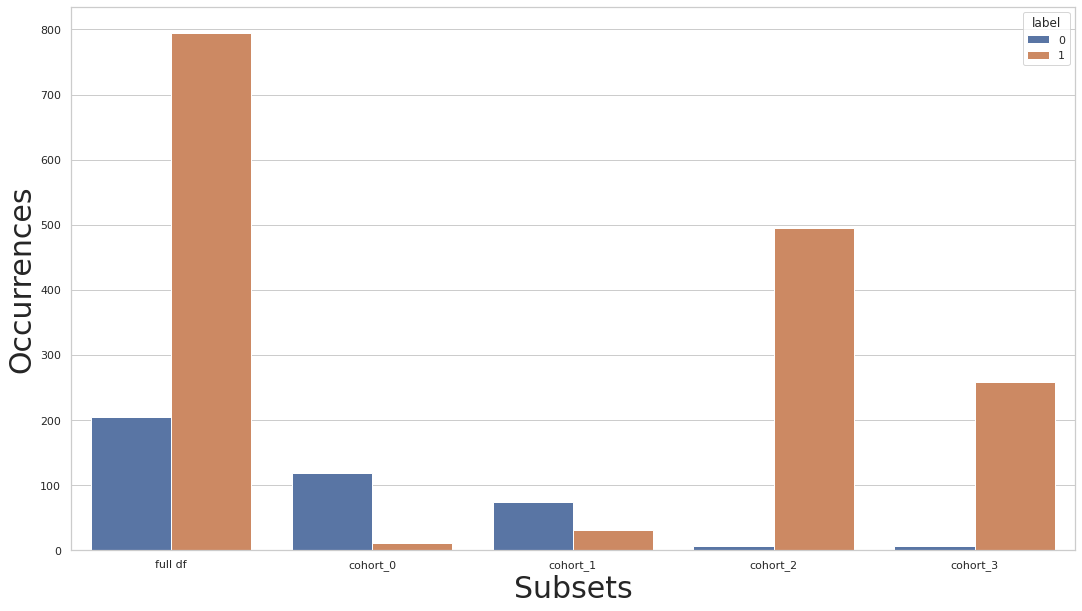

In [33]:
X, y = create_df(with_null=False)

cohort_set = CohortManager(
    cohort_col=["CN_1_num_1"]
)
cohort_set.fit(X=X, y=y)
subsets = cohort_set.get_subsets(X, y, apply_transform=False)

print(y.value_counts())
for key in subsets.keys():
    print(subsets[key]["y"].value_counts())

plot_value_counts_cohort(y, subsets, normalize=False)

We can see that the full dataset has a great imbalance, where we have a considerably larger number of occurrences of the ``1`` class in relation to the ``0`` class. This imbalance is even greater for cohorts ``cohort_2`` and ``cohort_3``, while for cohorts ``cohort_0`` and ``cohort_1`` this imbalance is inverted: there are a lot more instances from the ``0`` class when compared to the ``1`` class.

### Balancing the full dataset

Let's now rebalance the full dataset. Here, We use the ``Rebalance`` class from the ``dataprocessing`` module. Afterward, we plot the label distributions once more to see if our problem is solved.

label
0        795
1        795
dtype: int64
label
0        463
1         11
dtype: int64
label
0        313
1         31
dtype: int64
label
1        495
0          8
dtype: int64
label
1        258
0         11
dtype: int64


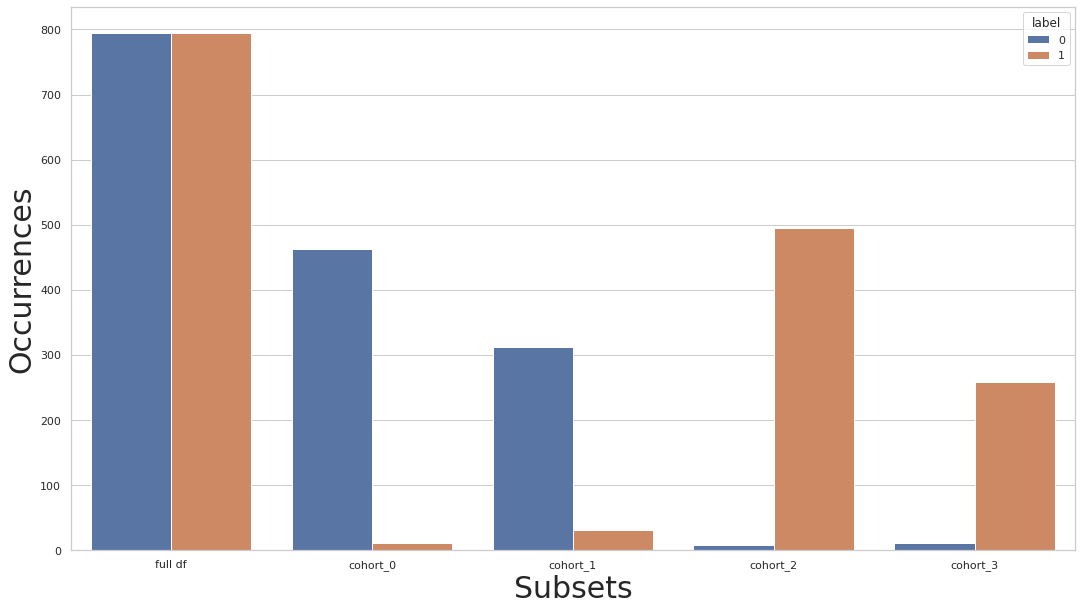

In [34]:
rebalance = dp.Rebalance(verbose=False)
new_X, new_y = rebalance.fit_resample(X, y)

cohort_set.fit(X=new_X, y=new_y)
subsets = cohort_set.get_subsets(new_X, new_y, apply_transform=False)

print(new_y.value_counts())
for key in subsets.keys():
    print(subsets[key]["y"].value_counts())

plot_value_counts_cohort(new_y, subsets, normalize=False)

As we can see, the full dataset is now balanced. However, looking at each cohort separately, we noticed that we only made matters worse: we now have an even greater label imbalance inside each cohort. If we think of these cohorts as sensitive groups, that is, groups separated by sensitive features, *e.g.* gender, race, and nationality, and that we don't want our models to perform differently in one group compared to another, then this imbalance between cohorts is a scenario that needs to be fixed.

### Balancing each cohort separately

We'll now use the ``Rebalance`` class over each cohort separately, in order to obtain a set of balanced cohorts. This might aid us in obtaining fair models, that is, models that perform equally through cohorts. To do this, we'll use the ``CohortManager``, and we'll pass the ``Rebalance`` object to the ``transform_pipe`` parameter. We'll then call the ``fit_resample()`` method, implemented by the ``Rebalance`` class. Note that when using a pipeline with an object that implements the ``fit_resample()`` class, there can't be any transformers that implement the ``transform()`` and ``predict()`` methods, since these transformations serve different purposes: the former is used for rebalancing, that is, creating new instances in the ``X`` and ``y`` datasets, while the latter require that the number of instances of the dataset is kept fixed between each transformation.

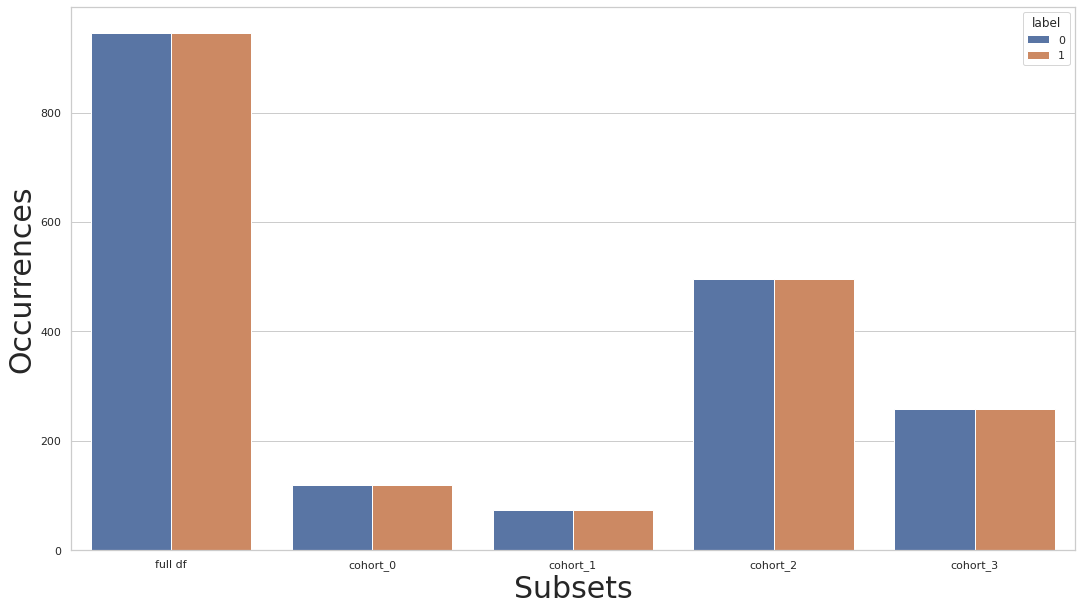

In [35]:
rebalance_cohort = CohortManager(
    transform_pipe=dp.Rebalance(verbose=False),
    cohort_col=["CN_1_num_1"]
)
new_X, new_y = rebalance_cohort.fit_resample(X, y)

subsets = rebalance_cohort.get_subsets(new_X, new_y, apply_transform=False)

plot_value_counts_cohort(new_y, subsets, normalize=False)

In [36]:
new_y.value_counts()

0    946
1    946
Name: label, dtype: int64

As we can see, we now have a balanced full dataset, while also having balanced cohorts.

## Balancing only a set of cohorts

Suppose that we trained a model that is under-performing only for cohorts ``cohort_2`` and ``cohort_3``. In this case, we can keep the remaining cohorts unchanged, and balance only cohorts ``cohort_2`` and ``cohort_3`. To do this, we can use a separate pipeline for each cohort, where cohorts ``cohort_2`` and ``cohort_3` use a pipeline comprised with only a ``Rebalance`` object, while the other two cohorts use an empty pipeline.

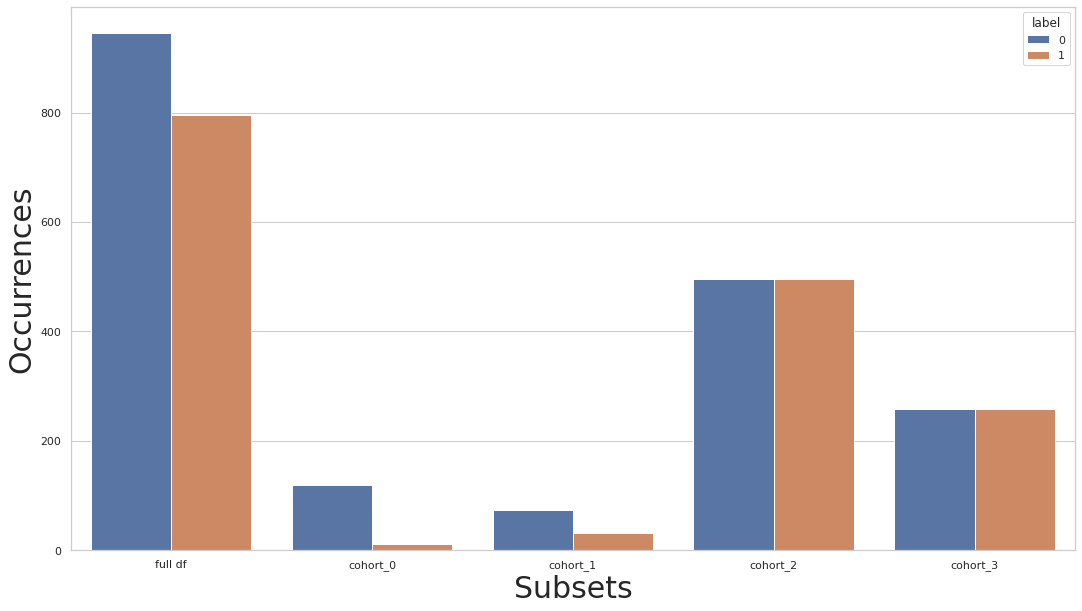

In [37]:
rebalance_cohort = CohortManager(
    transform_pipe=[
        [],
        [],
        [dp.Rebalance(verbose=False)],
        [dp.Rebalance(verbose=False)],
    ],
    cohort_col=["CN_1_num_1"]
)
new_X, new_y = rebalance_cohort.fit_resample(X, y)

subsets = rebalance_cohort.get_subsets(new_X, new_y, apply_transform=False)

plot_value_counts_cohort(new_y, subsets, normalize=False)